In [1]:
from copy import copy,deepcopy
import json
import matplotlib.pyplot as plt
import pandas as pd
import time
import textwrap

In [2]:
import requests
import requests_cache


requests_cache.install_cache("pfocr_cache", allowable_methods=['GET', 'POST'])

# BTE Sleeve

Why do we get slightly different values for the Fisher's Exact test? Scroll down the the "Fisher's Exact Test" section to see and compare the calculations.

## Get BTE TRAPI Results

In [3]:
query = {
    "message": {
        "query_graph": {
            "edges": {
                "e0": {
                    "subject": "n0",
                    "object": "n1",
                    "predicates": [
                        "biolink:entity_regulates_entity",
                        "biolink:genetically_interacts_with"
                    ]
                },
                "e1": {
                    "subject": "n1",
                    "object": "n2",
                    "predicates": [
                        "biolink:related_to"
                    ]
                }
            },
            "nodes": {
                "n0": {
                    "ids": [
                        "NCBIGene:7454"
                    ],
                    "categories": [
                        "biolink:Gene"
                    ]
                },
                "n1": {
                    "categories": [
                        "biolink:Gene"
                    ],
                },
                "n2": {
                    "categories": [
                        "biolink:SmallMolecule"
                    ]
                }
            }
        }
    }
}

trapi_response = requests.post("http://localhost:3000/v1/query", json=query)
#trapi_response = requests.post("https://api.bte.ncats.io/v1/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/rtxkg2/v1.2/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/arax/v1.2/query", json=query)
print(trapi_response.status_code)
if trapi_response.status_code != 200:
    print(trapi_response.text)
if trapi_response.from_cache:
    print(f"got response from cache")

trapi_message = trapi_response.json()["message"]

#print(json.dumps(query))

200
got response from cache


In [4]:
# NOTE: we're including categories specified in the query template
# in the next cell, and in a cell further down, we're also including
# any categories from the TRAPI results.
#
# TODO: Some categories are supersets of others. Should we handle
# this systematically?

curie_categories = set()
for v in query["message"]["query_graph"]["nodes"].values():
    if "categories" in v:
        for category in v["categories"]:
            curie_categories.add(category)

In [5]:
# for genes/gene products, chemicals and diseases
preferred_prefixes = set(["NCBIGene", "MESH"])
unified_names = set()
unified_curies = set()
unification_failed_curies = set()
unified_prefixes = set()
all_prefixes = set()
curie_to_name = dict()
curie_to_unified_curie = dict()
for k, v in trapi_message["knowledge_graph"]["nodes"].items():
    name = v["name"]
    for category in v["categories"]:
        curie_categories.add(category)
        
    for a in v["attributes"]:
        if a["attribute_type_id"] == "biolink:xref":
            curies = a["value"]
            
            # k should always be one of the curies
            if not k in curies:
                raise Exception(f"key {k} not in {curies}")
            
            unified_curie = None
            intersecting_unified_curies = unified_curies.intersection(set(curies))
            if len(intersecting_unified_curies) > 1:
                raise Exception(f"matching multiple: {k} to {list(intersecting_unified_curies)}")
            elif len(intersecting_unified_curies) == 1:
                unified_curie = list(intersecting_unified_curies)[0]
            else:
                # get curie for preferred prefix. usually this is k, but not always.
                for curie in curies:
                    [prefix, identifier] = curie.split(":")
                    if prefix in preferred_prefixes:
                        unified_curie = curie
                        unified_curies.add(unified_curie)
                        break
                        
            if not unified_curie:
                if k in curie_to_unified_curie:
                    unified_curie = curie_to_unified_curie[k]
                else:
                    unification_failed_curies.add(k)
                    break
                    
                #raise Exception(f"failed to find a unified curie for {k} in {curies}")
                
            [unified_prefix, unified_identifier] = unified_curie.split(":")
            unified_prefixes.add(unified_prefix)
            
            for curie in curies:
                [prefix, identifier] = curie.split(":")
                all_prefixes.add(prefix)
                if not curie in curie_to_unified_curie:
                    curie_to_unified_curie[curie] = unified_curie
                if not curie in curie_to_name:
                    curie_to_name[curie] = name
                    unified_names.add(name)
                elif curie_to_name[curie] != name:
                    print(f"curie {curie} has multiple primary names: {curie_to_name[curie]} and {name}")

curie UMLS:C0003779 has multiple primary names: Desmopressin and Argipressin


In [6]:
columns = []
q_node_id_keys = set(["object", "subject"])
q_node_ids = []
q_edge_ids = []
for q_edge_id,edge_v in query["message"]["query_graph"]["edges"].items():
    q_edge_ids.append(q_edge_id)
    q_node_id_found = False
    for k,v in edge_v.items():
        if (k in q_node_id_keys) and (type(v) is str):
            if v not in columns:
                q_node_ids.append(v)
                columns.append(v)
            if not q_node_id_found:
                q_node_id_found = True
                columns.append(q_edge_id)
                
for q_node_id in q_node_ids:
    columns.append(f"{q_node_id}_curie")
    columns.append(f"{q_node_id}_unified_curie")
    
columns.append("trapi_result_curie_combo")

trapi_result_columns = []
for i in range(len(q_node_ids)):
    trapi_result_columns.append(q_node_ids[i])
    if i < len(q_edge_ids):
        trapi_result_columns.append(q_edge_ids[i])

In [7]:
trapi_results = trapi_message["results"]

result_row_data = []
for trapi_result in trapi_results:
    curie_to_qnode_ids = dict()
    for qnode_id, entries in trapi_result["node_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            if curie not in curie_to_qnode_ids:
                curie_to_qnode_ids[curie] = []
            curie_to_qnode_ids[curie].append(qnode_id)
        
    row_data_template = dict()
    q_edge_id_to_predicates = dict()
    trapi_result_curies = set()
    for qedge_id, entries in trapi_result["edge_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            kg_entry = trapi_message["knowledge_graph"]["edges"][curie]
            subject_curie = kg_entry["subject"]
            object_curie = kg_entry["object"]
            predicate_curie = kg_entry["predicate"]
            [predicate_prefix, predicate_identifier] = predicate_curie.split(":")
            
            if qedge_id not in q_edge_id_to_predicates:
                q_edge_id_to_predicates[qedge_id] = set()
            q_edge_id_to_predicates[qedge_id].add(predicate_identifier)

            for curie in [subject_curie, object_curie]:
                for qnode_id in curie_to_qnode_ids[curie]:
                    if curie in curie_to_unified_curie:
                        unified_curie = curie_to_unified_curie[curie]
                    else:
                        break

                    name = curie_to_name[curie]
                    row_data_template[qnode_id] = name

                    trapi_result_curies.add(unified_curie)
                    row_data_template[qnode_id + "_curie"] = curie
                    row_data_template[qnode_id + "_unified_curie"] = unified_curie
                    
    if len(trapi_result_curies) != len(q_node_ids):
        #print(f'skipping {list(curie_to_qnode_ids.keys())}')
        continue
        
    row_data_template["trapi_result_curie_combo"] = tuple(sorted(trapi_result_curies))
    q_edge_ids_processed = set()
    row_datas = [row_data_template]
    for q_edge_id,predicates in q_edge_id_to_predicates.items():
        next_row_datas = []
        for row_data in row_datas:
            for predicate in predicates:
                next_row_data = deepcopy(row_data)
                next_row_data[q_edge_id] = predicate
                next_row_datas.append(
                    next_row_data 
                )
        row_datas = next_row_datas
    result_row_data += row_datas
        
results_df = pd.DataFrame.from_records(result_row_data, columns=columns).drop_duplicates()

## Match up BTE TRAPI Results & PFOCR

In [8]:
pfocr_url = "https://www.dropbox.com/s/1f14t5zaseocyg6/bte_chemicals_diseases_genes.ndjson?dl=1"
pfocr_request = requests.get(pfocr_url)
print(f"status_code: {pfocr_request.status_code}")
if pfocr_request.status_code != 200:
    print(pfocr_request.text)

status_code: 200


In [9]:
curies_to_figure_ids = {}
figure_id_to_curies = {}
figure_id_to_pfocr_result = {}
for line in pfocr_request.text.splitlines():
    pfocr_result = json.loads(line)
    figure_id = pfocr_result["_id"]

    curies = set()
    for identifier in pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]:
        curie = "MESH:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]:
        curie = "MESH:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]:
        curie = "NCBIGene:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)

    figure_id_to_pfocr_result[figure_id] = pfocr_result
    figure_id_to_curies[figure_id] = curies

    curies_key = tuple(sorted(curies))
    if curies_key not in curies_to_figure_ids:
        curies_to_figure_ids[curies_key] = []
    curies_to_figure_ids[curies_key].append(figure_id)

In [10]:
from SetSimilaritySearch import SearchIndex

# the reference sets are supposed to be from PFOCR only
reference_sets = list()
for curies in set(curies_to_figure_ids.keys()):
    reference_sets.append(set(curies))
# but in order to calculate the scores correctly,
# the SetSimilaritySearch library requires that
# every curie from the bte results need to be
# mentioned at least once in the reference set.
# That's the only reason we add them below, as
# one large set.

unified_curie_columns = [
    q_node_id + "_unified_curie" for q_node_id in q_node_ids
]

trapi_result_curie_combos = set()
for i, df in results_df[unified_curie_columns].drop_duplicates().iterrows():
    trapi_result_curies = []
    for unified_curie_column in unified_curie_columns:
        trapi_result_curies.append(
            df[unified_curie_column]
        )
    trapi_result_curie_combos.add(tuple(sorted(
        trapi_result_curies
    )))
    
reference_set = set()
for trapi_result_curie_combo in trapi_result_curie_combos:
    reference_set |= set(trapi_result_curie_combo)
reference_sets.append(reference_set)

matchable_node_min = 2
matchable_node_count = len(q_node_ids)
index = SearchIndex(reference_sets, similarity_func_name="containment", 
    similarity_threshold=matchable_node_min/matchable_node_count)

trapi_figure_overlap_rows = []
for trapi_result_curie_combo in trapi_result_curie_combos:
    trapi_curies = set(trapi_result_curie_combo)
    results = index.query(trapi_curies)
    for result in results:
        figure_curie_combos = reference_sets[result[0]]
        figure_curie_key = tuple(sorted(figure_curie_combos))
        
        # needed to not match bte results to themselves
        if figure_curie_key in curies_to_figure_ids:
            figure_ids = curies_to_figure_ids[figure_curie_key]
        else:
            continue
            
        score = result[1]
        
        common_curies = trapi_curies.intersection(figure_curie_combos)
        for figure_id in figure_ids:
            pfocr_result = figure_id_to_pfocr_result[figure_id]
            trapi_figure_overlap_rows.append({
                "figure_id": figure_id,
                "figure_url": pfocr_result["associatedWith"]["figureUrl"],
                "figure_title": pfocr_result["associatedWith"]["title"],
                "trapi_result_curie_combo": trapi_result_curie_combo,
                "figure_curie_combo": figure_curie_key,
                "overlap_curie_combo": tuple(sorted(common_curies)),
                "score": score,
            })


trapi_figure_overlap_df = pd.DataFrame.from_records(trapi_figure_overlap_rows)

results_with_figures_df = trapi_figure_overlap_df.merge(
    results_df,
    on="trapi_result_curie_combo",
    how="left"
)

## Fisher's Exact Test

Is the two-sided (two-tailed) Fisher's Exact Test calculated correctly below?

I initially used the SciPy `stats.fisher_exact` method ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html)), but it was too slow -- took about 7 min to calculate all the p-values for about 500k rows. So I switched to the `pvalue_npy` method from the fisher package ([docs](https://pypi.org/project/fisher/)). This was much faster (<1 sec instead of 7 min), but for some inputs, the results are slightly different, probably due to the `.to_numpy('uint')` conversion. The difference appears minor, so I don't think it's worth worrying about.

In [11]:
all_genes = set()
gene_instance_count = 0
all_chemicals = set()
chemical_instance_count = 0
all_diseases = set()
disease_instance_count = 0
for figure_id, pfocr_result in figure_id_to_pfocr_result.items():
    genes = pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]
    for gene in genes:
        gene_instance_count += 1
        all_genes.add(gene)
        
    chemicals = pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]
    for chemical in chemicals:
        chemical_instance_count += 1
        all_chemicals.add(chemical)
        
    diseases = pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]
    for disease in diseases:
        disease_instance_count += 1
        all_diseases.add(disease)
    
print("total instance counts:")
print(f'  chemicals: {chemical_instance_count}')
print(f'  diseases: {disease_instance_count}')
print(f'  genes: {gene_instance_count}')

print("")

print("unique counts:")
print(f'  chemicals: {len(all_chemicals)}')
print(f'  diseases: {len(all_diseases)}')
print(f'  genes: {len(all_genes)}')

print("")

curie_category_to_curies = {
    "biolink:ChemicalEntity": all_chemicals,
    "biolink:SmallMolecule": all_chemicals,
    "biolink:Disease": all_diseases,
    "biolink:Gene": all_genes,
}


all_figure_curies = set()
for curie_category in set(curie_category_to_curies.keys()).intersection(curie_categories):
    all_figure_curies |= curie_category_to_curies[curie_category]
all_figure_curie_count = len(all_figure_curies)

print(f'M for Fisher Exact test: {all_figure_curie_count}')
print(
    'TODO: in the future, it might be more correct to base this number on all the CURIEs in BTE/TRAPI'
)

total instance counts:
  chemicals: 275456
  diseases: 20465
  genes: 1369680

unique counts:
  chemicals: 14482
  diseases: 1430
  genes: 14253

M for Fisher Exact test: 28735
TODO: in the future, it might be more correct to base this number on all the CURIEs in BTE/TRAPI


See [this contingency table](https://docs.google.com/spreadsheets/d/1d-48R5N0auuKXSLJ7oZ2E_ldO26Z5KiEH3AQx5kDrC4/edit#gid=0):

|      |  |
| ----------- | ----------- |
| trapi_curies_in_pwy      | q_node_id_count - trapi_curies_in_pwy       |
| curies_in_pwy - trapi_curies_in_pwy   | 28735 - curies_in_pwy - q_node_id_count + trapi_curies_in_pwy        |

and the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html):

|      |  |
| ----------- | ----------- |
| x      | n - x       |
| N - x   | M - (n + N) + x        |

and the [fisher documentation](https://pypi.org/project/fisher/):

|      |  |
| ----------------------- | ----------------------- |
| Selected & Having the property     | Selected & Not having the property |
| Not Selected & Having the property     | Not Selected & Not having the property |

In [12]:
# trapi_curies_in_pwy
# x
# Selected & Having the property
results_with_figures_df["yes_trapi_yes_pwy"] = (
    results_with_figures_df["overlap_curie_combo"].map(len)
)

# q_node_id_count - trapi_curies_in_pwy
# n - x
# Selected & Not Having the property
results_with_figures_df["yes_trapi_no_pwy"] = (
    len(q_node_ids) - results_with_figures_df["yes_trapi_yes_pwy"]
)

# curies_in_pwy - trapi_curies_in_pwy
# N - x
# Not Selected & Having the property
results_with_figures_df["no_trapi_yes_pwy"] = (
    results_with_figures_df["figure_curie_combo"].map(len) - 
    results_with_figures_df["yes_trapi_yes_pwy"]
)

# 28735 - curies_in_pwy - q_node_id_count + trapi_curies_in_pwy
# M - (n + N) + x
# Not Selected & Not Having the property
results_with_figures_df["no_trapi_no_pwy"] = (
    all_figure_curie_count -
    results_with_figures_df["figure_curie_combo"].map(len) -
    len(q_node_ids) +
    results_with_figures_df["yes_trapi_yes_pwy"]
)

In [13]:
import scipy.stats as stats


start = time.time()

results_with_figures_df["fishers_exact_slow"] = results_with_figures_df[
    ["yes_trapi_yes_pwy",
     "yes_trapi_no_pwy",
     "no_trapi_yes_pwy",
     "no_trapi_no_pwy"]
].apply(
    lambda r: stats.fisher_exact([[
        r.yes_trapi_yes_pwy,
        r.yes_trapi_no_pwy
    ], [
        r.no_trapi_yes_pwy,
        r.no_trapi_no_pwy,
    ]]),
    axis=1)

results_with_figures_df["p_value_slow"] = results_with_figures_df["fishers_exact_slow"].apply(
    lambda x: x[1]
)

end = time.time()
print(f'elapsed time: {end - start}')

elapsed time: 452.3985230922699


In [15]:
# see https://stackoverflow.com/a/58661068/5354298
from fisher import pvalue_npy


start = time.time()

_, _, twosided = pvalue_npy(
    results_with_figures_df["yes_trapi_yes_pwy"].to_numpy('uint'),
    results_with_figures_df["yes_trapi_no_pwy"].to_numpy('uint'),
    results_with_figures_df["no_trapi_yes_pwy"].to_numpy('uint'),
    results_with_figures_df["no_trapi_no_pwy"].to_numpy('uint'),
)
odds = (
    results_with_figures_df["yes_trapi_yes_pwy"].to_numpy('uint') *
    results_with_figures_df["no_trapi_no_pwy"].to_numpy('uint')
) / (
    results_with_figures_df["yes_trapi_no_pwy"].to_numpy('uint') *
    results_with_figures_df["no_trapi_yes_pwy"].to_numpy('uint')
)

results_with_figures_df["p_value_fast"] = pd.Series(twosided, index=results_with_figures_df.index)

end = time.time()
print(f'elapsed time: {end - start}')

elapsed time: 0.4414098262786865


/var/folders/89/ldcft7g57d75vkyg58ngcnhw0000gp/T/ipykernel_64747/1111999521.py:13: RuntimeWarning: divide by zero encountered in true_divide
  odds = (


### Compare

The histograms look the same:

(array([4.57475e+05, 4.79240e+04, 3.04580e+04, 1.24000e+02, 6.60200e+03,
        0.00000e+00, 6.80000e+01, 0.00000e+00, 1.00000e+00, 1.00000e+01]),
 array([2.52908245e-13, 4.78668596e-05, 9.57337190e-05, 1.43600578e-04,
        1.91467438e-04, 2.39334297e-04, 2.87201156e-04, 3.35068016e-04,
        3.82934875e-04, 4.30801735e-04, 4.78668594e-04]),
 <BarContainer object of 10 artists>)

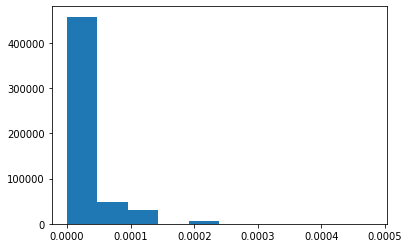

In [16]:
plt.hist(results_with_figures_df["p_value_slow"])

(array([4.57475e+05, 4.79240e+04, 3.04580e+04, 1.24000e+02, 6.60200e+03,
        0.00000e+00, 6.80000e+01, 0.00000e+00, 1.00000e+00, 1.00000e+01]),
 array([2.45068090e-10, 4.78670800e-05, 9.57339149e-05, 1.43600750e-04,
        1.91467585e-04, 2.39334420e-04, 2.87201254e-04, 3.35068089e-04,
        3.82934924e-04, 4.30801759e-04, 4.78668594e-04]),
 <BarContainer object of 10 artists>)

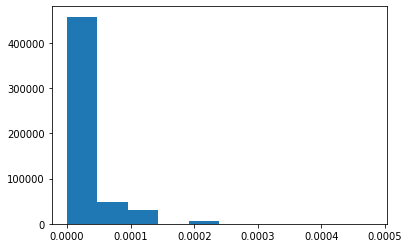

In [17]:
plt.hist(results_with_figures_df["p_value_fast"])

A small proportion of the total have a ratio that is not close to zero:

In [18]:
results_with_figures_df["p_value_ratio"] = (
    results_with_figures_df["p_value_slow"] / results_with_figures_df["p_value_fast"]
)

In [19]:
len(results_with_figures_df)

542662

In [20]:
len(results_with_figures_df[
    results_with_figures_df["p_value_ratio"] < 0.999
])

23

In [21]:
len(results_with_figures_df[
    results_with_figures_df["p_value_ratio"] > 1.001
])

0

In [22]:
print(
    results_with_figures_df["p_value_ratio"].sort_values()
)

36235     0.000012
36234     0.000012
36233     0.000012
36232     0.000012
36231     0.000012
            ...   
364691    1.000000
322043    1.000000
322044    1.000000
118808    1.000000
360776    1.000000
Name: p_value_ratio, Length: 542662, dtype: float64


In [23]:
print(results_with_figures_df["p_value_ratio"].min())
print(results_with_figures_df["p_value_ratio"].max())

1.160133183273141e-05
1.0000000000771918


The small number of values where the ratio isn't close to zero appear to be coming from very small p-values, e.g. `2.529082e-13` vs. `2.450681e-10`:

In [24]:
print(results_with_figures_df["p_value_slow"].sort_values())
print("")
print(results_with_figures_df["p_value_fast"].sort_values())

36227     2.529082e-13
36234     2.529082e-13
36235     2.529082e-13
36231     2.529082e-13
36230     2.529082e-13
              ...     
199545    4.786686e-04
538824    4.786686e-04
135252    4.786686e-04
187939    4.786686e-04
538823    4.786686e-04
Name: p_value_slow, Length: 542662, dtype: float64

36204     2.450681e-10
36203     2.450681e-10
36200     2.450681e-10
36199     2.450681e-10
36198     2.450681e-10
              ...     
199545    4.786686e-04
538824    4.786686e-04
135252    4.786686e-04
187939    4.786686e-04
538823    4.786686e-04
Name: p_value_fast, Length: 542662, dtype: float64


(array([2.30000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.42639e+05]),
 array([1.16013318e-05, 1.00010441e-01, 2.00009281e-01, 3.00008121e-01,
        4.00006961e-01, 5.00005801e-01, 6.00004641e-01, 7.00003480e-01,
        8.00002320e-01, 9.00001160e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

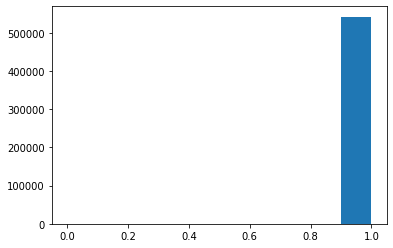

In [25]:
plt.hist(
    results_with_figures_df["p_value_ratio"]
)

(array([11.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  6.,  2.]),
 array([1.16013318e-05, 2.43663510e-05, 3.71313701e-05, 4.98963892e-05,
        6.26614083e-05, 7.54264274e-05, 8.81914466e-05, 1.00956466e-04,
        1.13721485e-04, 1.26486504e-04, 1.39251523e-04]),
 <BarContainer object of 10 artists>)

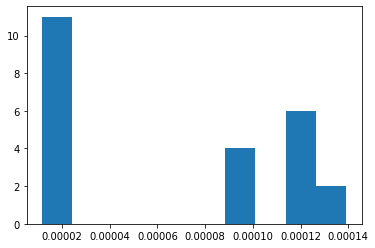

In [26]:
plt.hist(results_with_figures_df[
    results_with_figures_df["p_value_ratio"] < 0.999
]["p_value_ratio"])

(array([2.30000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.57191e+05]),
 array([1.16013318e-05, 1.00010441e-01, 2.00009281e-01, 3.00008121e-01,
        4.00006961e-01, 5.00005801e-01, 6.00004641e-01, 7.00003480e-01,
        8.00002320e-01, 9.00001160e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

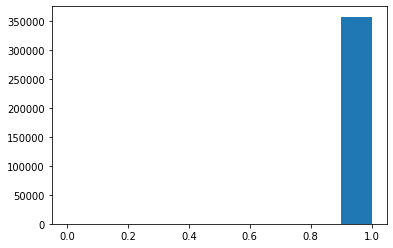

In [27]:
plt.hist(results_with_figures_df[
    results_with_figures_df["p_value_ratio"] < 1
]["p_value_ratio"])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

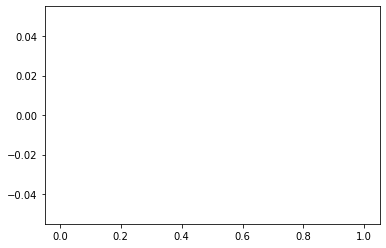

In [28]:
plt.hist(results_with_figures_df[
    results_with_figures_df["p_value_ratio"] == 1
]["p_value_ratio"])

(array([5.5786e+04, 4.5300e+04, 5.9275e+04, 1.2417e+04, 1.5200e+02,
        6.7680e+03, 6.0000e+00, 2.2470e+03, 9.7800e+02, 2.5190e+03]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 <BarContainer object of 10 artists>)

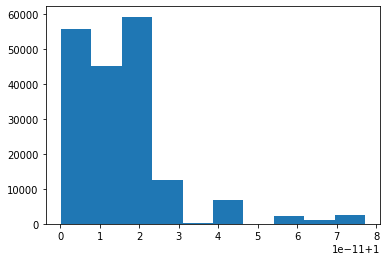

In [29]:
plt.hist(results_with_figures_df[
    results_with_figures_df["p_value_ratio"] > 1
]["p_value_ratio"])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

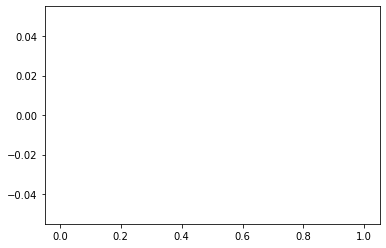

In [30]:
plt.hist(results_with_figures_df[
    results_with_figures_df["p_value_ratio"] > 1.001
]["p_value_ratio"])